In [1]:
from src.data import gedi_pipeline

import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
import matplotlib.pyplot as plt
palette = sns.color_palette("Set2")

sns.set_theme()
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.ee import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
from src.data import shape_processor
import matplotlib.pyplot as plt
from src.data import k_nn
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
from fastai.tabular.all import load_pickle, save_pickle, patch
from src.constants import DATA_PATH
from src.data import gedi_raster_matching
from src.processing.rf import split_data
from fastai.tabular.all import *
from sklearn.metrics import *
from src.utils.logging_util import get_logger
from sklearn.ensemble import RandomForestRegressor
from src.processing.rf import train
from sklearn.inspection import PartialDependenceDisplay
from fastbook import *

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)


2023-11-02 11:15:42,634 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-02 11:15:42,636 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-02 11:15:42,637 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-02 11:15:42,638 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [2]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_11()

In [3]:
GEDI_PATH = f"{DATA_PATH}/gedi_intermediate"
gedi_burned = load_pickle(
    f"{GEDI_PATH}/sierras_gedi_combined_stage_11_burned_with_controls_Oct29.pkl")

In [4]:
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_std == 0]
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_median.isin([1, 2, 5])]
#gedi_burned = gedi_burned[gedi_burned.dw_land_cover_median.isin([1, 5])]
gedi_burned = gedi_burned.dropna()
gedi_unburned = gedi_unburned.dropna()
gedi_burned = gedi_burned[gedi_burned.time_since_burn < 36]

In [5]:
gedi_burned = gedi_burned[gedi_burned.burn_count == 1]

In [6]:
sierra_conservancy = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")

In [7]:
gedi_unburned_sc = gedi_unburned.sjoin(sierra_conservancy, how="inner", predicate="within")

In [14]:
gedi_burned = gedi_burned.drop(columns=["index_right"])

In [15]:
gedi_burned_sc = gedi_burned.sjoin(sierra_conservancy, how="inner", predicate="within")

In [16]:
gedi_burned = gedi_burned_sc
gedi_unburned = gedi_unburned_sc

In [18]:
save_pickle(f"{GEDI_PATH}/gedi_burned_for_rf_Nov_2.pkl", gedi_burned)
save_pickle(f"{GEDI_PATH}/gedi_unburned__for_rf_Nov_2.pkl", gedi_unburned)

: 

# High Severity

In [214]:
high_severity = gedi_burned[(gedi_burned.severity == 4)]

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

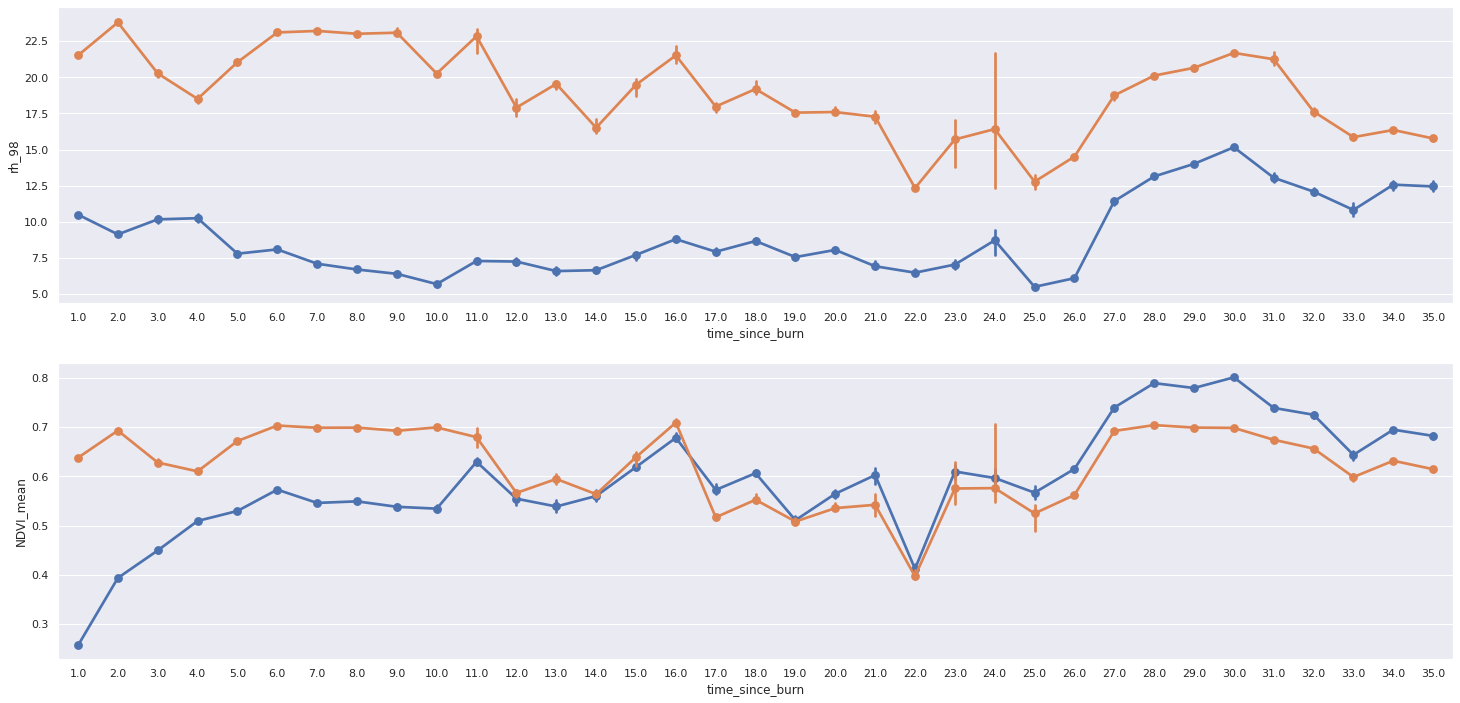

In [222]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = high_severity
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="rh_98_control",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_control",  ax=ax[1], estimator="median")

(0.0, 1.0)

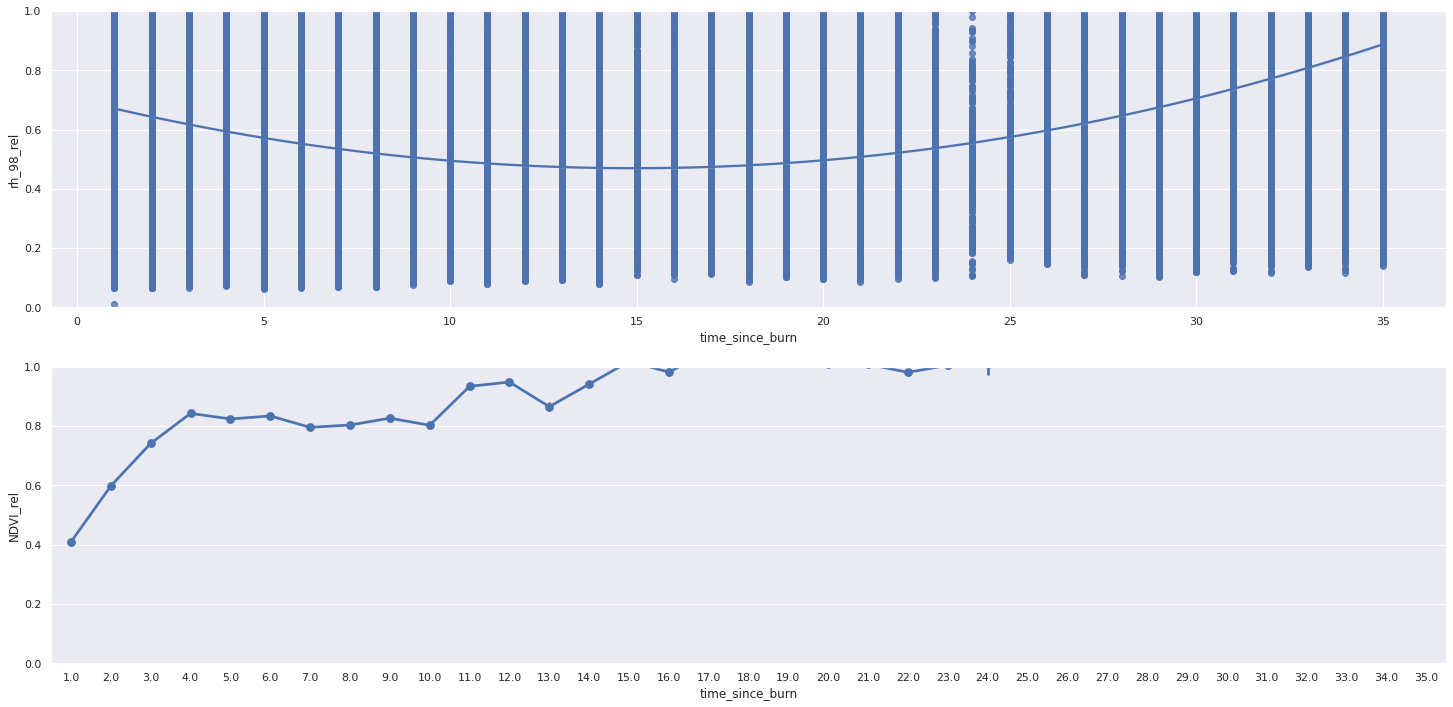

In [226]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12), sharey=True)
df = high_severity
sns.regplot(df, x="time_since_burn", y="rh_98_rel",  ax=ax[0], order=2)
sns.pointplot(df, x="time_since_burn", y="NDVI_rel",  ax=ax[1], estimator="median")
ax[0].set_ylim((0, 1))
ax[0].set_ylim((0, 1))

# Low Severity

In [196]:
low_severity = gedi_burned[(gedi_burned.severity == 2)]

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

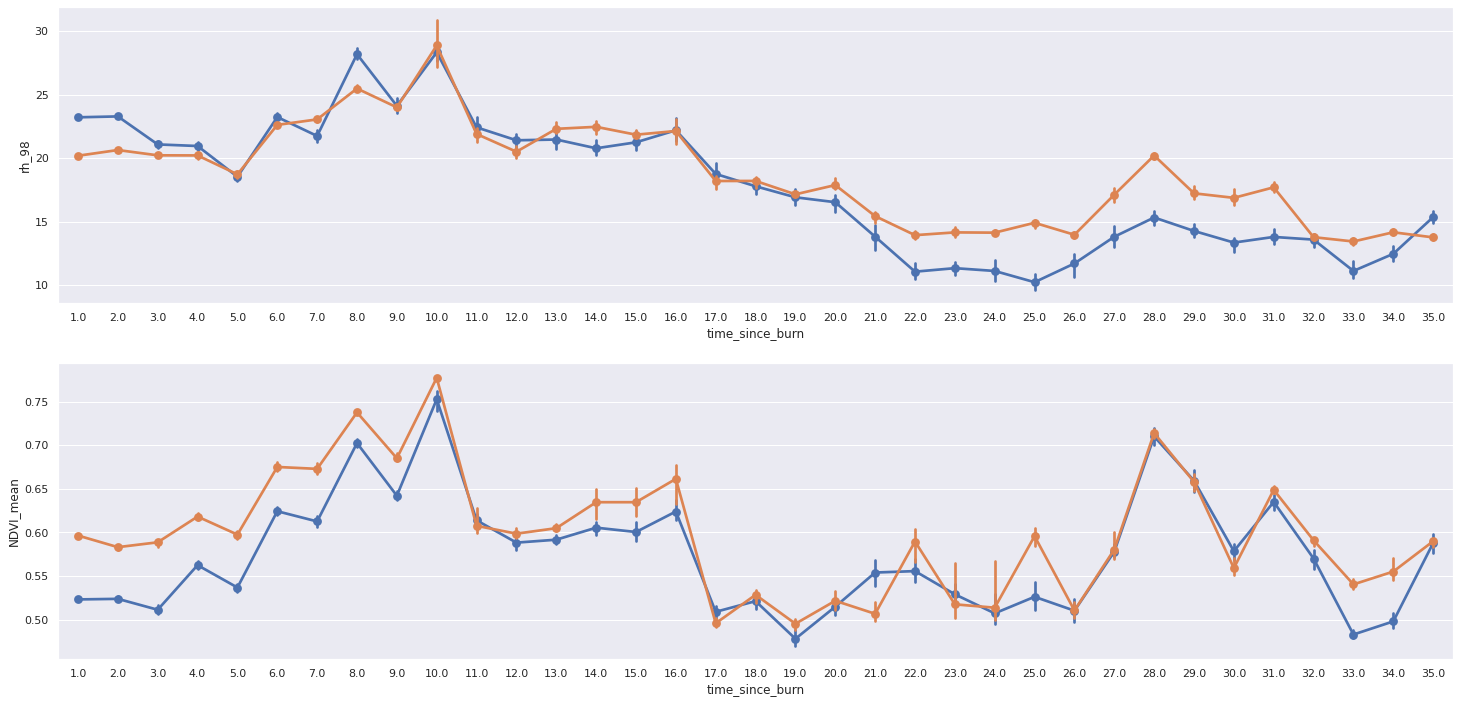

In [219]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = low_severity
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="rh_98_control",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_control",  ax=ax[1], estimator="median")

(0.0, 1.3)

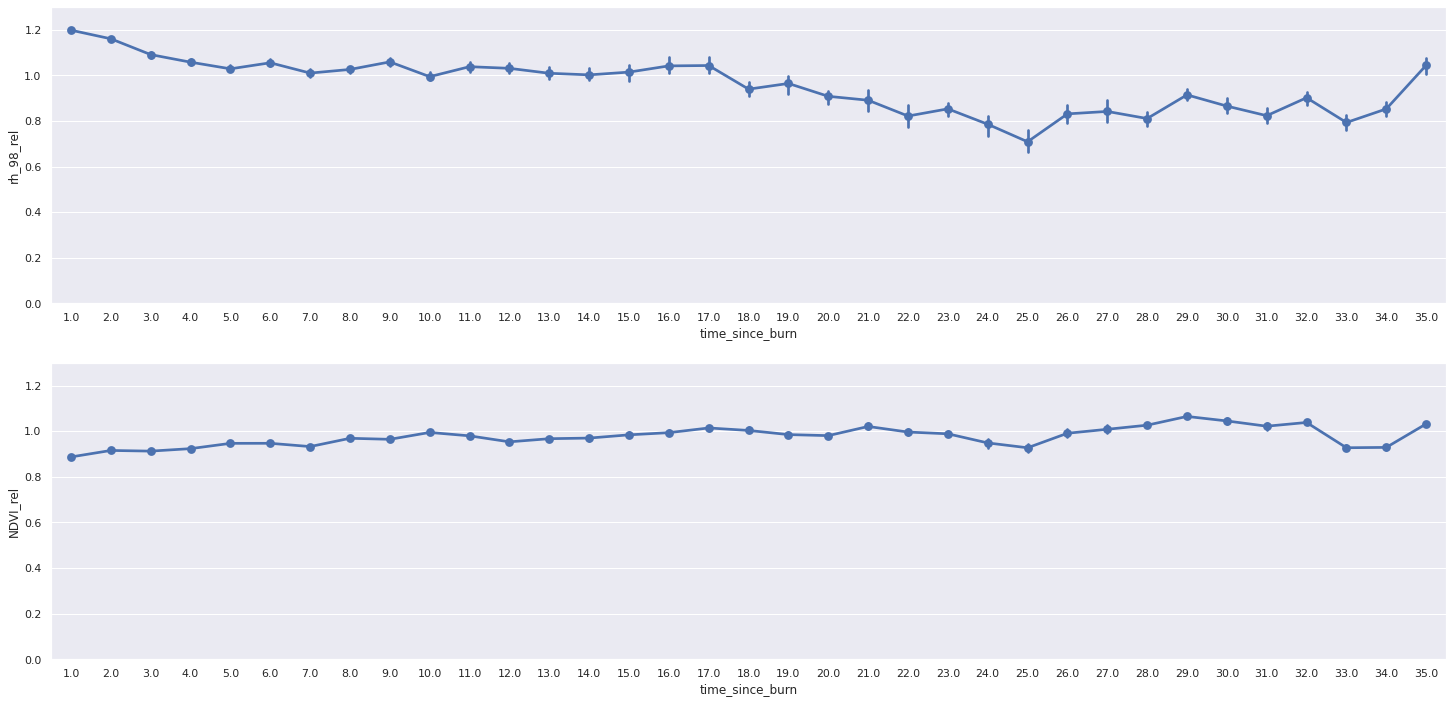

In [221]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12), sharey=True)
df = low_severity
sns.pointplot(df, x="time_since_burn", y="rh_98_rel",  ax=ax[0], estimator="median")
sns.pointplot(df, x="time_since_burn", y="NDVI_rel",  ax=ax[1], estimator="median")
ax[0].set_ylim((0, 1.3))

<AxesSubplot: xlabel='time_since_burn', ylabel='elevation_median'>

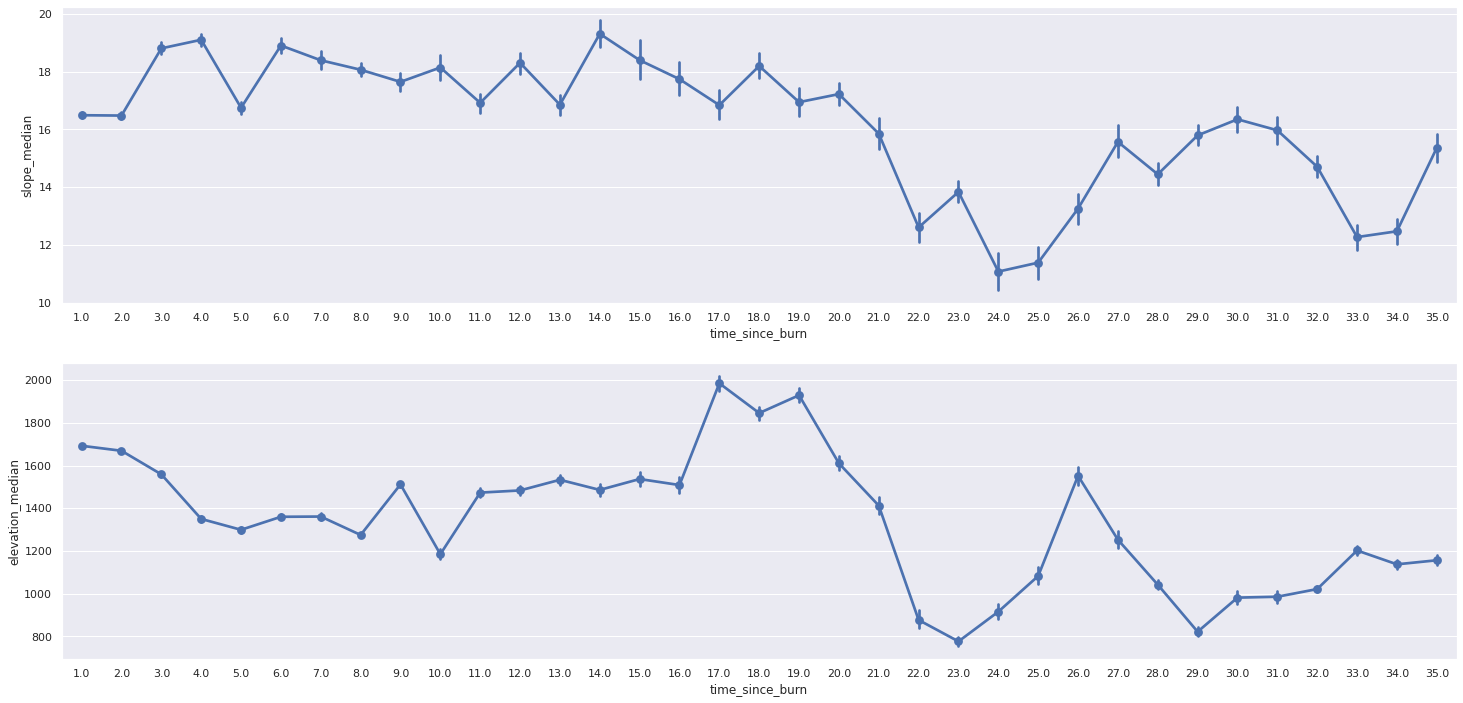

In [218]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = low_severity
sns.pointplot(df, x="time_since_burn", y="slope_median",  ax=ax[0])
sns.pointplot(df, x="time_since_burn", y="elevation_median",  ax=ax[1])

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

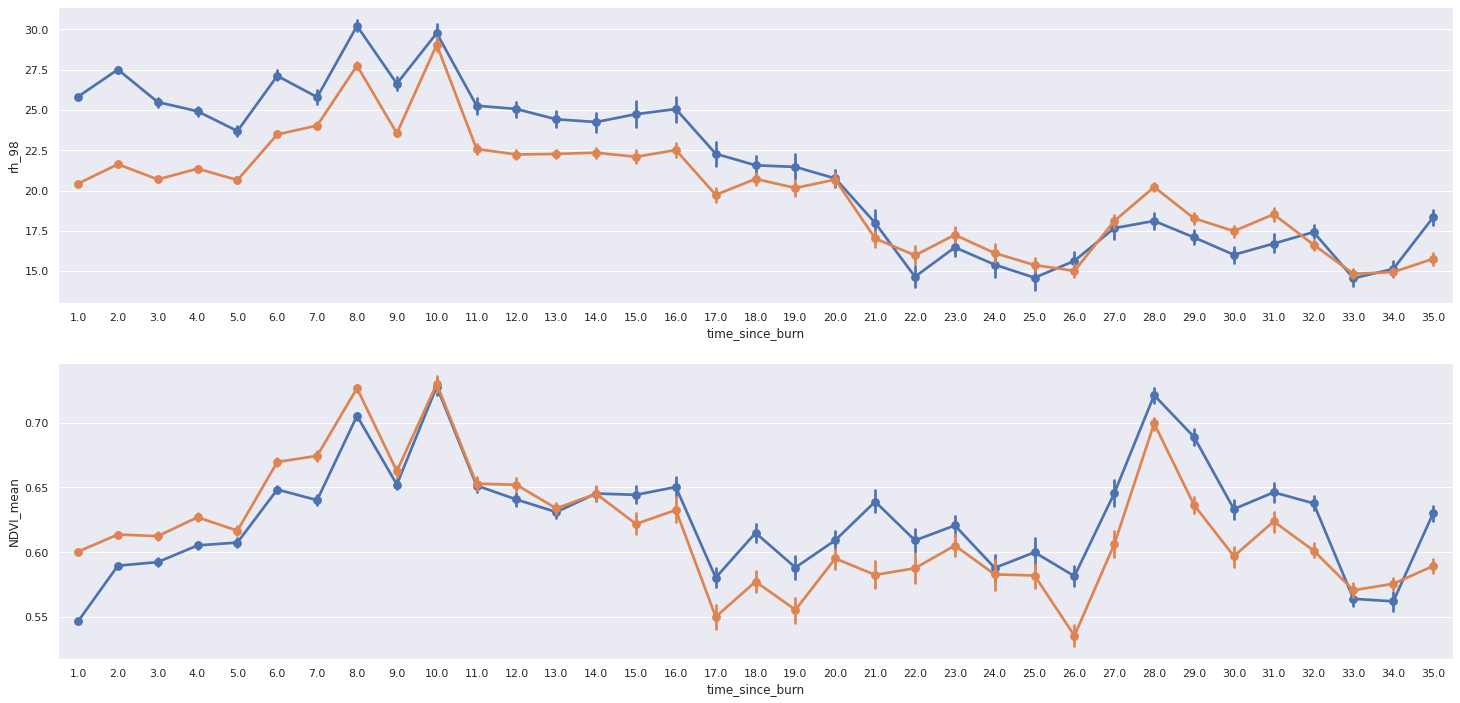

In [213]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
df = low_severity[low_severity.dw_land_cover_median == 1]
sns.pointplot(df, x="time_since_burn", y="rh_98",  ax=ax[0])
sns.pointplot(df, x="time_since_burn", y="rh_98_control",  ax=ax[0])
sns.pointplot(df, x="time_since_burn", y="NDVI_mean",  ax=ax[1])
sns.pointplot(df, x="time_since_burn", y="NDVI_control",  ax=ax[1])

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

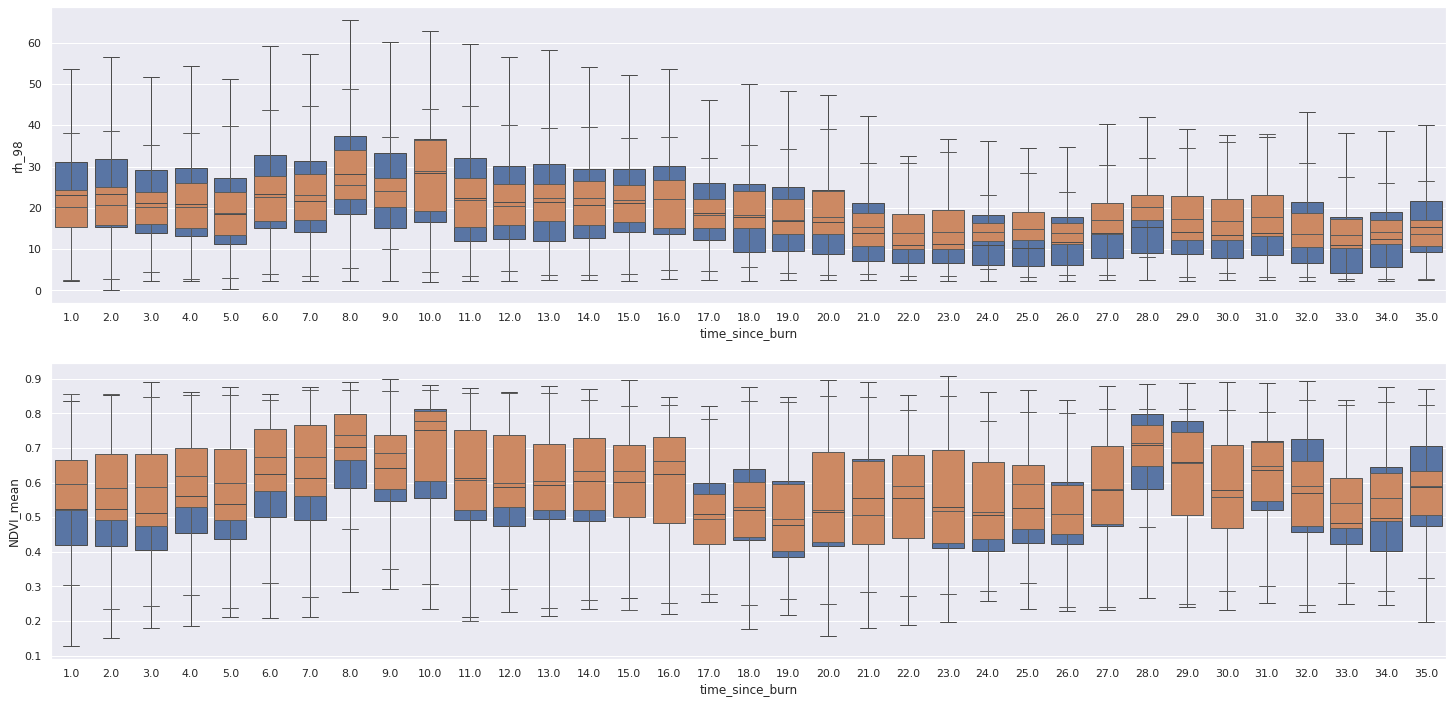

In [198]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.boxplot(low_severity, x="time_since_burn", y="rh_98",  ax=ax[0], showfliers=False)
sns.boxplot(low_severity, x="time_since_burn", y="rh_98_control",  ax=ax[0], showfliers=False)
sns.boxplot(low_severity, x="time_since_burn", y="NDVI_mean",  ax=ax[1], showfliers=False)
sns.boxplot(low_severity, x="time_since_burn", y="NDVI_control",  ax=ax[1], showfliers=False)

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98'>

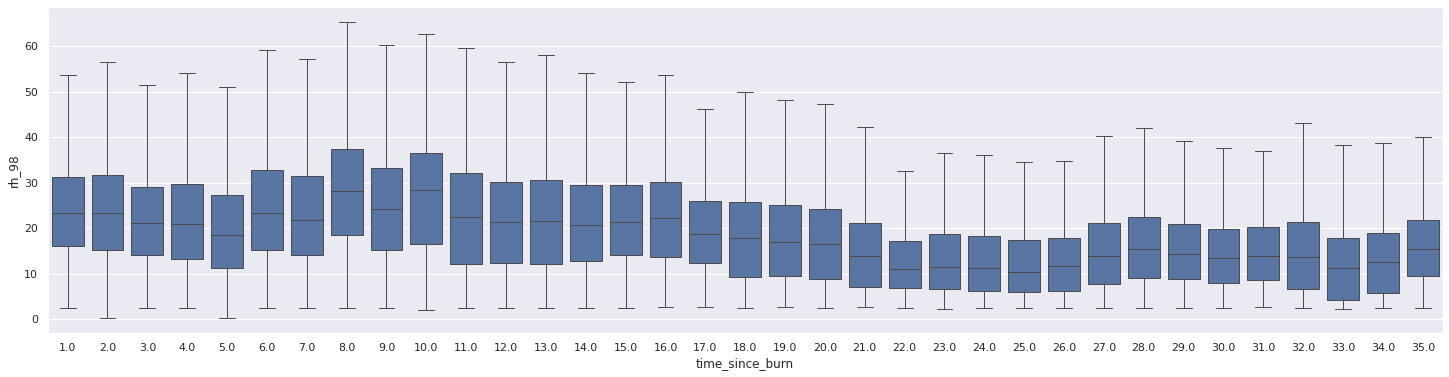

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.boxplot(low_severity, x="time_since_burn", y="rh_98",  ax=ax, showfliers=False)

In [200]:
low_10 = low_severity[low_severity.time_since_burn < 11]
low_20 = low_severity[(low_severity.time_since_burn < 32) & (low_severity.time_since_burn >= 22)]

(0.0, 5.0)

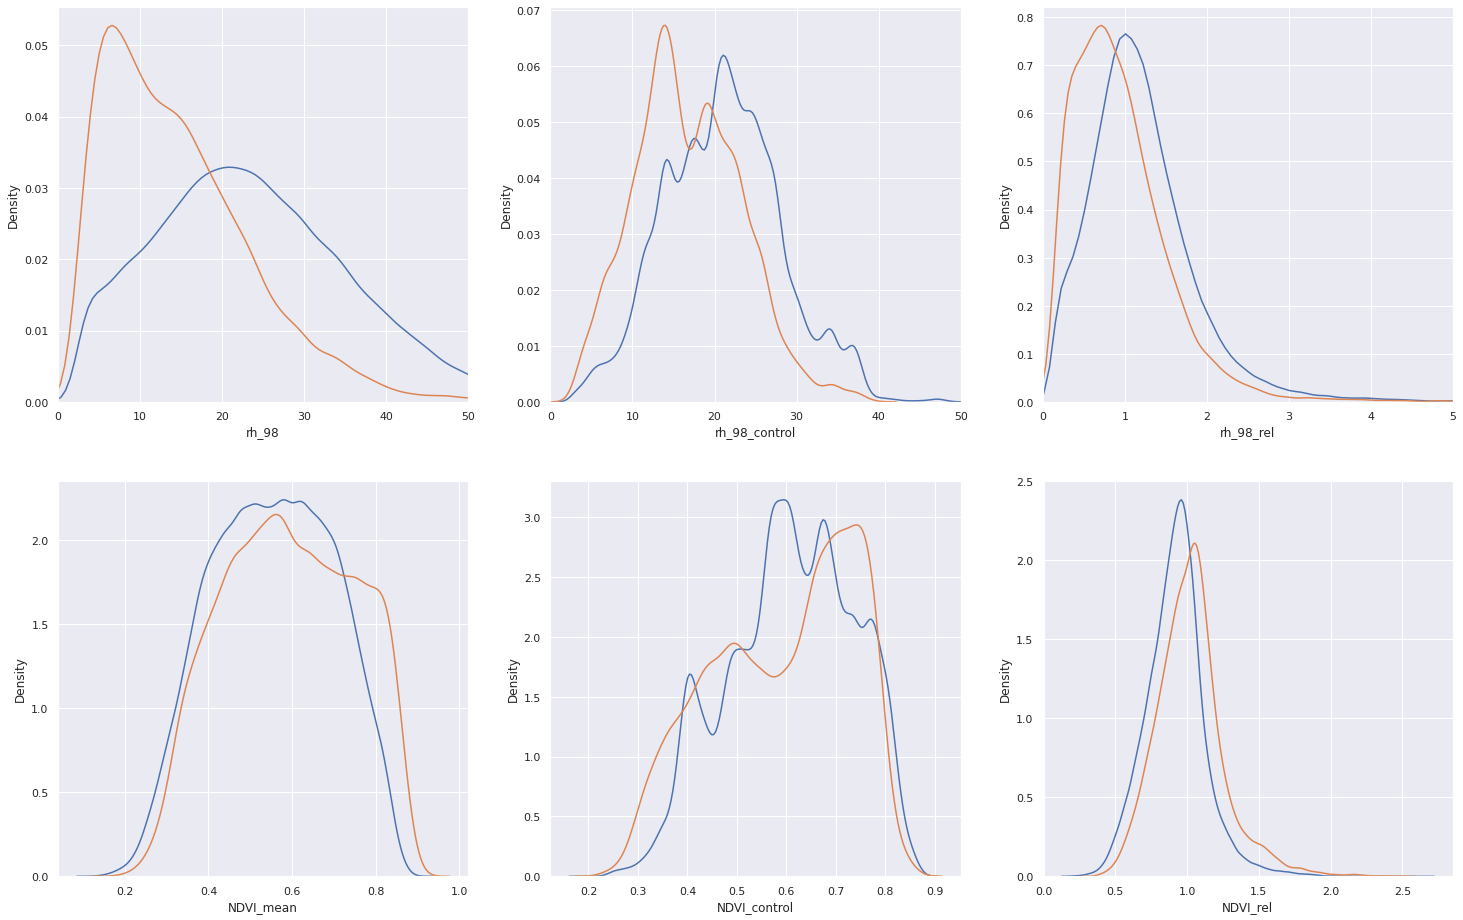

In [201]:
fig, ax = plt.subplots(2, 3, figsize=(25, 16))
sns.kdeplot(low_10, x="rh_98", ax=ax[0][0])
sns.kdeplot(low_20, x="rh_98", ax=ax[0][0])
sns.kdeplot(low_10, x="rh_98_control", ax=ax[0][1])
sns.kdeplot(low_20, x="rh_98_control", ax=ax[0][1])
sns.kdeplot(low_10, x="rh_98_rel", ax=ax[0][2])
sns.kdeplot(low_20, x="rh_98_rel", ax=ax[0][2])
sns.kdeplot(low_10, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_20, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_10, x="NDVI_control", ax=ax[1][1])
sns.kdeplot(low_20, x="NDVI_control", ax=ax[1][1])
sns.kdeplot(low_10, x="NDVI_rel", ax=ax[1][2])
sns.kdeplot(low_20, x="NDVI_rel", ax=ax[1][2])
ax[0][0].set_xlim((0, 50))
ax[0][1].set_xlim((0, 50))
ax[0][2].set_xlim((0, 5))

(0.0, 5.0)

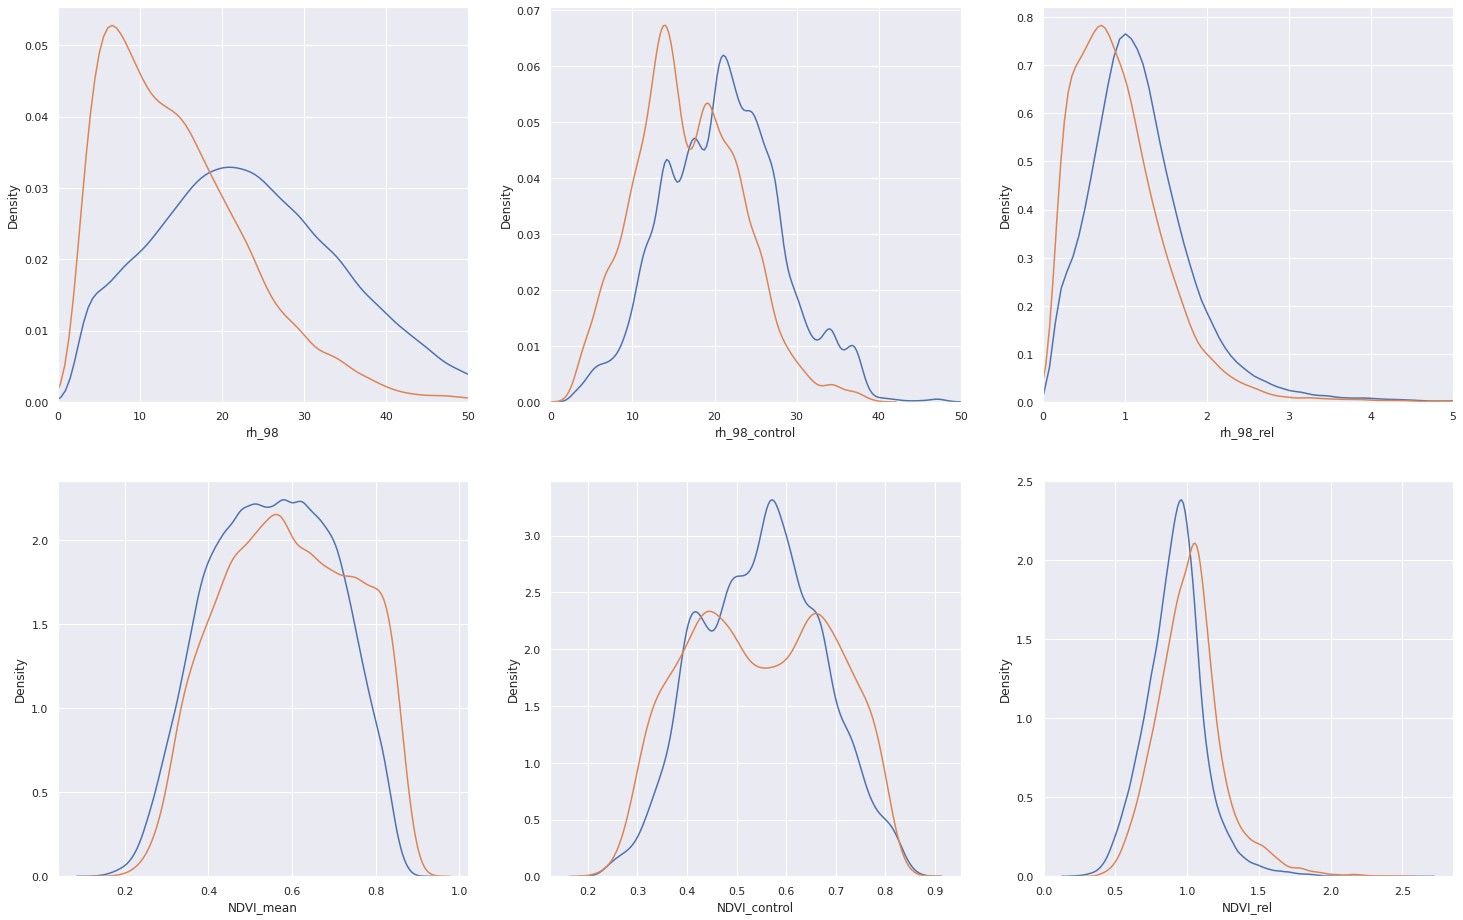

In [202]:
fig, ax = plt.subplots(2, 3, figsize=(25, 16))
sns.kdeplot(low_10, x="rh_98", ax=ax[0][0])
sns.kdeplot(low_20, x="rh_98", ax=ax[0][0])
sns.kdeplot(low_10, x="rh_98_control", ax=ax[0][1])
sns.kdeplot(low_20, x="rh_98_control", ax=ax[0][1])
sns.kdeplot(low_10, x="rh_98_rel", ax=ax[0][2])
sns.kdeplot(low_20, x="rh_98_rel", ax=ax[0][2])
sns.kdeplot(low_10, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_20, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_10[low_10.rh_98 < 10], x="NDVI_control", ax=ax[1][1])
sns.kdeplot(low_20[low_20.rh_98 < 10], x="NDVI_control", ax=ax[1][1])
sns.kdeplot(low_10, x="NDVI_rel", ax=ax[1][2])
sns.kdeplot(low_20, x="NDVI_rel", ax=ax[1][2])
ax[0][0].set_xlim((0, 50))
ax[0][1].set_xlim((0, 50))
ax[0][2].set_xlim((0, 5))

In [135]:
df = low_10[(low_10.rh_98 > 50)]
print(len(df))
df = df.sample()
print(f"{float(df.latitude.iloc[0])}, {float(df.longitude.iloc[0])}")
df[["rh_98", "elevation_difference_tdx", "slope_median", "elevation_median", "NDVI_mean", "time_since_burn", "burn_year","dw_land_cover_median"]]

2673
39.05853212414231, -120.87631306997272


,rh_98,elevation_difference_tdx,slope_median,elevation_median,NDVI_mean,time_since_burn,burn_year,dw_land_cover_median
7843603,55.59,-64.994904,38.381981,495.5,0.726224,7.0,2012.0,1.0


# Slope & Height

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

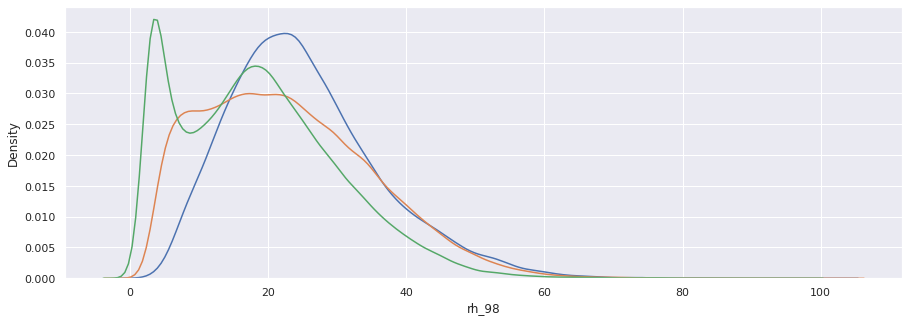

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = low_severity
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="rh_98", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

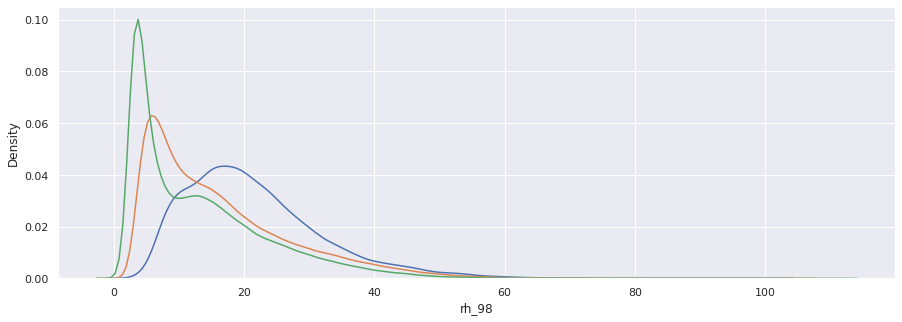

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = gedi_burned
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="rh_98", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

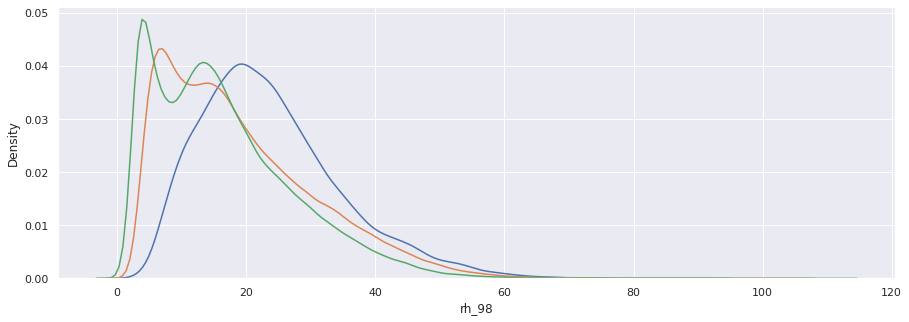

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = gedi_burned[gedi_burned.dw_land_cover_median == 1]
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="rh_98", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

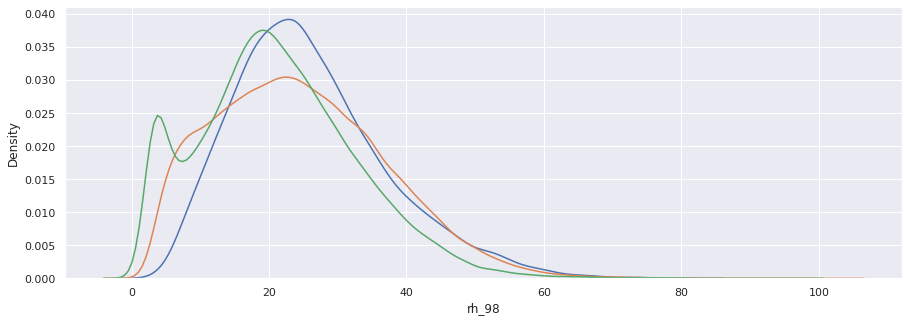

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = low_10
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="rh_98", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

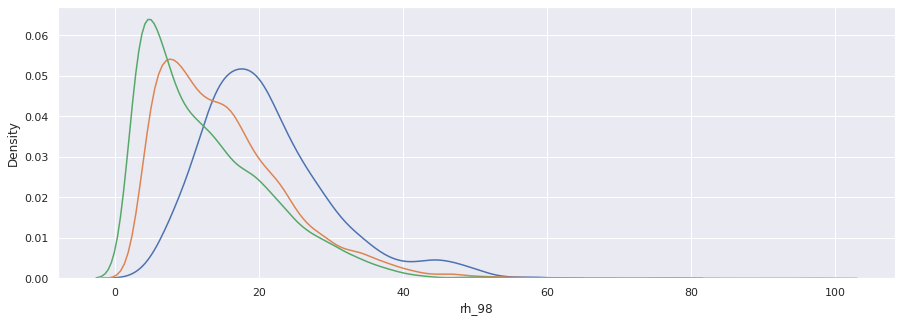

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = low_20
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="rh_98", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

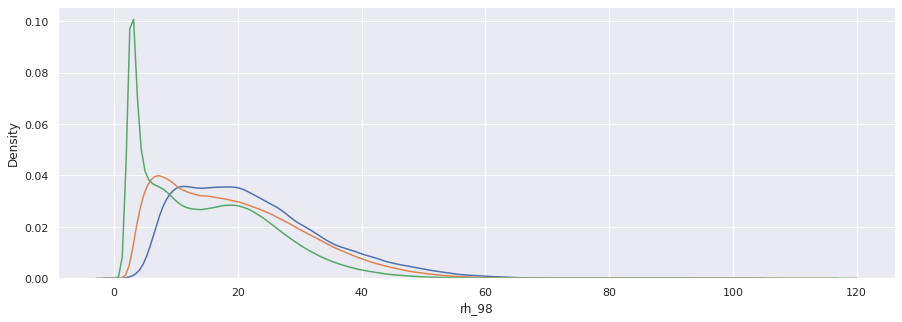

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = gedi_unburned
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="rh_98", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='NDVI_mean', ylabel='Density'>

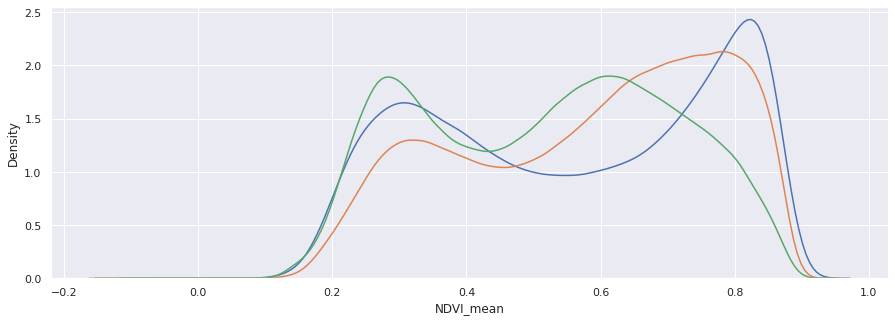

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = gedi_unburned
sns.kdeplot(df[df.slope_median > 30], x="NDVI_mean", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="NDVI_mean", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="NDVI_mean", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

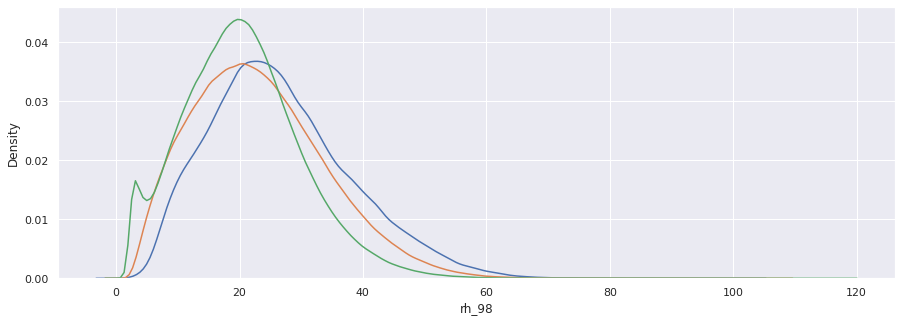

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = gedi_unburned[gedi_unburned.dw_land_cover_median == 1]
sns.kdeplot(df[df.slope_median > 30], x="rh_98", ax=ax)
sns.kdeplot(df[(df.slope_median > 10) & (df.slope_median < 30)], x="rh_98", ax=ax)
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

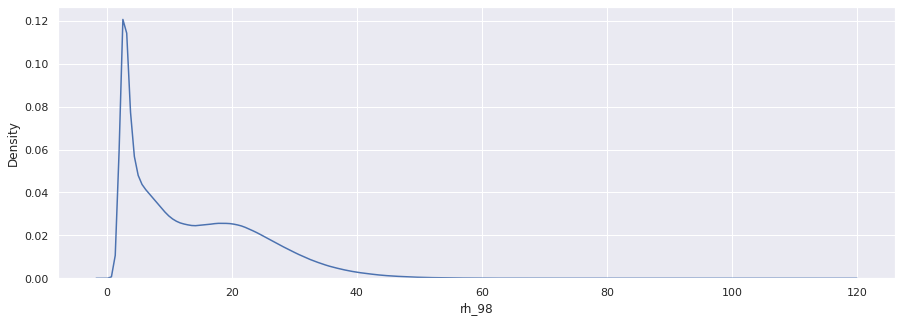

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df = gedi_unburned
sns.kdeplot(df[df.slope_median < 10], x="rh_98", ax=ax)

<AxesSubplot: xlabel='rh_98', ylabel='Density'>

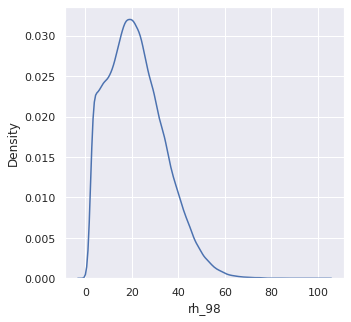

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(low_severity, x="rh_98", ax=ax)

In [151]:
df = gedi_unburned[(gedi_unburned.slope_median < 10) & (gedi_unburned.rh_98 < 10)]
print(len(df))
df = df.sample()
print(f"{float(df.latitude.iloc[0])}, {float(df.longitude.iloc[0])}")
df[["rh_98", "elevation_difference_tdx", "slope_median", "elevation_median", "NDVI_mean", "time_since_burn", "burn_year","dw_land_cover_median"]]

1099489
38.677588471268834, -119.16337208799531


,rh_98,elevation_difference_tdx,slope_median,elevation_median,NDVI_mean,time_since_burn,burn_year,dw_land_cover_median
12590131,6.43,0.638672,7.679574,2356.0,0.384353,-1,0.0,5.0


<AxesSubplot: xlabel='dw_land_cover_median', ylabel='Count'>

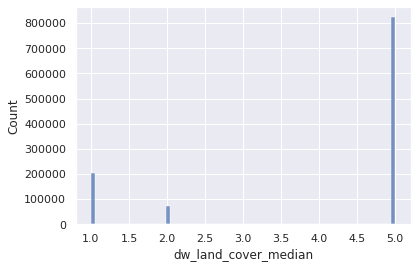

In [152]:
df = gedi_unburned[(gedi_unburned.slope_median < 10) & (gedi_unburned.rh_98 < 10)]
sns.histplot(df, x="dw_land_cover_median")

<AxesSubplot: xlabel='time_since_burn', ylabel='Count'>

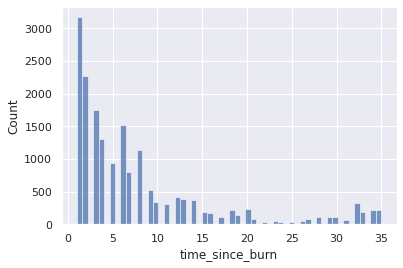

In [155]:
df = low_severity[(low_severity.slope_median >30 )]
sns.histplot(df, x="time_since_burn")

<AxesSubplot: xlabel='time_since_burn', ylabel='Count'>

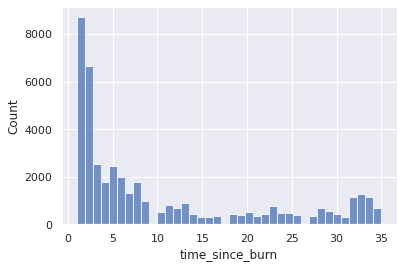

In [156]:
df = low_severity[(low_severity.slope_median <10 )]
sns.histplot(df, x="time_since_burn")

In [190]:
lala = gedi_unburned[(gedi_unburned.slope_median < 10) & (gedi_unburned.rh_98 < 10) & (gedi_unburned.dw_land_cover_median == 1)]
print(len(lala))

155633


In [195]:
df = lala.sample()
print(f"{float(df.latitude.iloc[0])}, {float(df.longitude.iloc[0])}")
df[["rh_98", "elevation_difference_tdx", "slope_median", "elevation_median", "NDVI_mean", "time_since_burn", "burn_year","dw_land_cover_median"]]

40.33302163724433, -122.03809423305863


,rh_98,elevation_difference_tdx,slope_median,elevation_median,NDVI_mean,time_since_burn,burn_year,dw_land_cover_median
10711233,9.54,-1.362671,1.824236,244.5,0.542343,-1,0.0,1.0
